In [2]:
import zipfile
#zip_file_path = "dog-and-cat.zip"
DATA_PATH = "dog-and-cat"
#with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#    zip_ref.extractall(DATA_PATH)

In [3]:
import os
from os import makedirs, listdir
from shutil import copyfile
from random import seed, random
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [4]:
# check data
# modify the below path if needed
train_folder = "./dog-and-cat/dog-and-cat/training_set"
test_folder = "./dog-and-cat/dog-and-cat/test_set"
train_dataset = ImageFolder(train_folder)
test_dataset = ImageFolder(test_folder)
# %%
# check data
train_file_names = []
train_labels = []
test_file_names = []
test_labels = []

for label in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, label)
    if os.path.isdir(label_folder):
        for file in os.listdir(label_folder):
            if file.endswith('.jpg'):
                train_file_names.append(file)
                train_labels.append(file[0:3])

for label in os.listdir(test_folder):
    label_folder = os.path.join(test_folder, label)
    if os.path.isdir(label_folder):
        for file in os.listdir(label_folder):
            if file.endswith('.jpg'):
                test_file_names.append(file)
                test_labels.append(file[0:3])

training_data = {'id': train_file_names, 'label': train_labels, 'split': "train"}
testing_data = {'id': test_file_names, 'label': test_labels, 'split': "test"}

training_df = pd.DataFrame(training_data)
testing_df = pd.DataFrame(testing_data)

df = pd.concat([training_df, testing_df], ignore_index=True)
# split val and train 1:9
train_df, val_df = train_test_split(training_df, test_size=0.2, random_state=2023)
train_df = train_df.iloc[:, :2]
val_df = val_df.iloc[:, :2]
test_df = testing_df.iloc[:, :2]

print('The shape of train data',train_df.shape)
print('The shape of test data',test_df.shape)
print('The shape of val data',val_df.shape)
print('The shape of all data', df.shape)

The shape of train data (6404, 2)
The shape of test data (2023, 2)
The shape of val data (1601, 2)
The shape of all data (10028, 3)


In [5]:
# build torch dataset
class DogCatLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(
            dataset
        )  # some images are CMYK, Grayscale, check only RGB
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory

    # 非 RGB 圖片會被忽略
    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if Image.open(dataset[index][0]).getbands() == (
                "R",
                "G",
                "B",
            ):  # Check Channels
                datasetRGB.append(dataset[index])
        return datasetRGB

In [6]:
# edit here if needed
image_size = 224
image_channel = 3 # RGB
batch_size = 64

In [7]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.1),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) params from Imagenet
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) params from Imagenet
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [8]:
# 將訓練資料再切分為 Train、Validation
training_set = ImageFolder(train_folder)

train_data, valid_data, train_label, valid_label = train_test_split(
    training_set.imgs, training_set.targets, test_size=0.1, random_state=42
)

train_dataset = DogCatLoader(train_data, train_transform)
valid_dataset = DogCatLoader(valid_data, valid_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# setting GPU
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"train on device: {device}")

train on device: cuda


In [10]:
# model
class ImageClassifier(nn.Module):
    def __init__(self, num_classes, image_size, image_channel):
        super().__init__()
        # input_size: 3*224*224
        self.conv1 = nn.Sequential(
            nn.Conv2d(image_channel, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
            ) # 32*112*112
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2),
            ) # 64*56*56
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2), 
            ) # 128*28*28
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.2)
            ) # 256*14*14
        
        self.fc1 = nn.Sequential(
            nn.Linear(256*(image_size//16)*(image_size//16), 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            )

        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = output.view(-1, 256*(image_size//16)*(image_size//16)) # flatten
        output = self.fc1(output)
        output = self.fc2(output)

        return output

In [11]:
# training loop def
from tqdm import tqdm
def training_loop(n_epochs, optimizer, scheduler, model, loss_fn, train_loader, val_loader, patience = 5):
    best_val_accuracy = 0.0  
    early_stopping_patience = patience
    no_improvement_counter = 0
    for epoch in range(n_epochs):
        loss_train = 0.0
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}', unit='batch') as t:
            for images, labels in t:
                images = images.to(device=device)
                labels = labels.to(device=device)
                outputs = model(images)  # one batch at a time
                loss = loss_fn(outputs, labels)
                optimizer.zero_grad()

                loss.backward()
                optimizer.step()
                loss_train += loss.item()

        val_accuracy, val_loss, train_accuracy = validate(model, train_loader, val_loader, loss_fn)
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)

        print(f'loss: {loss_train/(len(train_loader))}, acc: {train_accuracy}, val_loss: {val_loss/(len(val_loader))}, val_acc: {val_accuracy}, lr:{current_lr}')
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement_counter = 0
        else: 
            no_improvement_counter += 1

        if no_improvement_counter >= early_stopping_patience:
            print(f"Early stopping after {epoch+1} epochs.")
            break

In [12]:
# validation def
def validate(model, train_loader, val_loader, loss_fn, testing = False):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        if name == "train" and testing == True:
            train_accuracy = None
            continue
        else:
            correct = 0
            total = 0
            total_loss = 0
            with torch.no_grad():
                for imgs, labels in loader:
                    imgs = imgs.to(device=device)
                    labels = labels.to(device=device)
                    outputs = model(imgs)
                    _, predicted = torch.max(outputs, dim=1)

                    total += labels.shape[0]
                    correct += int((predicted == labels).sum())
                    loss = loss_fn(outputs, labels)
                    total_loss += loss.item()

            if name == "val":
                val_accuracy = correct / total
                val_loss = total_loss
            
            if name == "train":
                train_accuracy = correct / total
    
    return val_accuracy, val_loss, train_accuracy    

In [35]:
model = ImageClassifier(2, image_size, image_channel).to(device=device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True, min_lr=0.00001)

In [47]:
# strat training
model.train()
training_loop(
    n_epochs=40,
    optimizer=optimizer,
    scheduler=scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=valid_loader,
    patience=5
)

Epoch 1/5: 100%|██████████| 113/113 [00:41<00:00,  2.71batch/s]


loss: 0.41661724711941406, acc: 0.8119100499722376, val_loss: 0.37090354011609006, val_acc: 0.8339575530586767, lr:3.125e-05


Epoch 2/5: 100%|██████████| 113/113 [00:41<00:00,  2.71batch/s]


loss: 0.4124149928050759, acc: 0.8033037201554691, val_loss: 0.3561023725913121, val_acc: 0.8377028714107366, lr:3.125e-05


Epoch 3/5: 100%|██████████| 113/113 [00:42<00:00,  2.68batch/s]


loss: 0.4066690860596378, acc: 0.8110771793448084, val_loss: 0.35934112622187686, val_acc: 0.8339575530586767, lr:3.125e-05


Epoch 4/5: 100%|██████████| 113/113 [00:41<00:00,  2.72batch/s]


loss: 0.4112357162268816, acc: 0.8126041088284287, val_loss: 0.36883389720549953, val_acc: 0.8277153558052435, lr:3.125e-05


Epoch 5/5: 100%|██████████| 113/113 [00:42<00:00,  2.67batch/s]


Epoch 00040: reducing learning rate of group 0 to 1.5625e-05.
loss: 0.40835632383823395, acc: 0.8103831204886174, val_loss: 0.3570525004313542, val_acc: 0.8414481897627965, lr:3.125e-05


In [48]:
# testing data
testing_set = ImageFolder(test_folder)
test_dataset = DogCatLoader(testing_set.imgs, valid_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [49]:
model.eval()
test_loss = 0
correct = 0
test_accuracy, test_loss, _ = validate(model, train_loader, test_loader, loss_fn, testing=True)

print(f"Test Average Loss: {test_loss / len(test_loader)}, Test Accuracy: {test_accuracy}")

Test Average Loss: 0.32498977216891944, Test Accuracy: 0.8591201186356896


Predicted class: dog


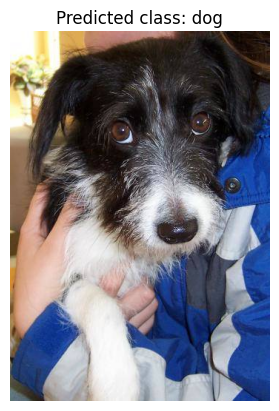

In [54]:
# using model
import matplotlib.pyplot as plt
from matplotlib.image import imread
def predict_and_display_image(image_path, model):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    image = transform(image)
    image = image.unsqueeze(0).to(device = device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        
    _, predicted = torch.max(output, 1)
    if predicted.item() == 0:
        category = 'cat'
    else:
        category = 'dog'
    
    print(f"Predicted class: {category}")

    image = imread(image_path)
    plt.imshow(image)
    plt.title(f"Predicted class: {category}")
    plt.axis('off')
    plt.show()
    
image_path = testing_set.imgs[1090][0]  # change
predict_and_display_image(image_path, model)

In [31]:
# save model
torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        "model_40epochs_pth",
    )

In [45]:
# %%
#load_model
loaded_model = ImageClassifier(2, image_size, image_channel).to(device=device)
loaded_optimizer = torch.optim.Adam(loaded_model.parameters())  
checkpoint = torch.load('model_40epochs_pth')

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [46]:
loaded_model.eval()
test_loss = 0
correct = 0
test_accuracy, test_loss, _ = validate(loaded_model, train_loader, test_loader, loss_fn, testing=True)

print(f"Test Average Loss: {test_loss / len(test_loader)}, Test Accuracy: {test_accuracy}")

Test Average Loss: 0.305485961958766, Test Accuracy: 0.8754325259515571
